In [53]:
import alg.main as model
import pandas as pd
pd.set_option('display.max_columns', None)
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

# COVID-19 DATA

Average lenghth of samples: 16.282666666666668


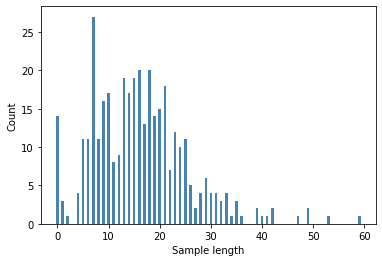

In [51]:
# dataset
data_df = pd.read_excel('data/time_series_375_prerpocess_en.xlsx',index_col=[0])
# sample length count
count=data_df.groupby(['PATIENT_ID'])['RE_DATE'].count().reset_index()
sum_count=count.groupby(['RE_DATE']).count().reset_index()
sample_length=sum_count['RE_DATE'].tolist()
sample_length_count=sum_count['PATIENT_ID'].tolist()
# average length
total=0.0
counts=0.0
for i in range(len(sample_length)):
    total=total+sample_length[i]*sample_length_count[i]
    counts=counts+sample_length_count[i]
print("Average lenghth of samples: "+str(total/counts))
plt.figure(figsize=(6,4))
plt.bar(sample_length,sample_length_count, width=0.5 , color='steelblue')
plt.ylabel('Count')
plt.xlabel('Sample length')
plt.show()

# 

# MODEL TEST

### Load model

In [47]:
def load_pkl(path):
    with open(path,'rb') as f:
        obj = pickle.load(f)
        return obj
def ShowGRAHeatMap(DataFrame):

    f, ax = plt.subplots(figsize=(6, 8))
   
    sns.heatmap(DataFrame,
                cmap="coolwarm",
                annot=False,)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.4, top - 0.4)
    plt.show()

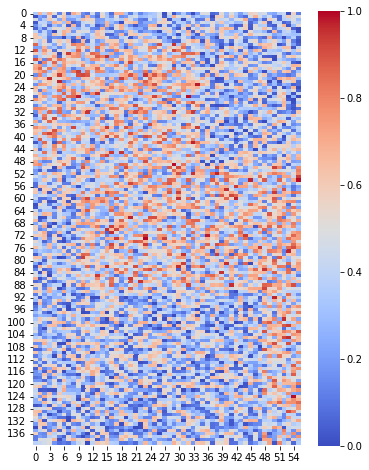

In [50]:
# show parameters
par_state=load_pkl('emb/ParStates')
ShowGRAHeatMap(par_state)

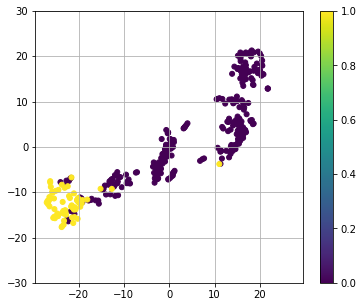

In [59]:
# show sample embeddings
path_string = 'emb/states.seqs'
with open(path_string,'rb') as f:
    states = pickle.load(f)
path_string = 'emb/SurvivalStates.seqs'
with open(path_string,'rb') as f:
    survival = pickle.load(f)
path_string = 'emb/DeadStates.seqs'
with open(path_string,'rb') as f:
    dead = pickle.load(f)
#all 327; survival 264; dead 63
#label survival0 dead1
emb=[]
emb_label=[] # survival dead
emb_stage=[] # statge
for i in range (len(survival)):
    for j in range(len(survival[i])):
        emb.append(survival[i][j])
        emb_label.append(0)
        emb_stage.append(i)
for i in range (len(dead)):
    for j in range(len(dead[i])):
        emb.append(dead[i][j])
        emb_label.append(1)
        emb_stage.append(i+6)

tsne = TSNE(n_components = 2)
projected=tsne.fit_transform(emb)
# dead (yellow) vs. sirvival (violet)
plt.figure(figsize=(6,5))
plt.scatter(projected[:,0],projected[:,1],c = emb_label,s=25)
plt.axis('equal')
plt.grid()
plt.colorbar()
plt.gca().set_ylim(-30,30)
plt.gca().set_xlim(-30,30)
plt.savefig('scatter.jpg', dpi=300)

# 

### Test

Test data is loaded!
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from model/
Test Accuracy = 0.812
Test AUC Micro = 0.930
Test AUC Macro = 0.885
[*] States saved at emb/states.seqs
Test data is loaded!
INFO:tensorflow:Restoring parameters from model/
Test Accuracy = 0.778
Test AUC Micro = 0.904
Test AUC Macro = 0.908
[*] States saved at emb/states.seqs
Test data is loaded!
INFO:tensorflow:Restoring parameters from model/
Test Accuracy = 0.760
Test AUC Micro = 

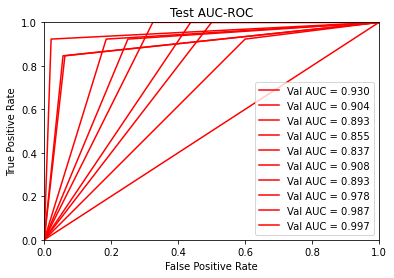

In [3]:
model_path='model/'
data_dir='StageBatchData/'
state_path='emb/states.seqs'
listfile = os.listdir(data_dir)
listfile=sorted(listfile,reverse = True)[:-1]
accuracy=[]
for dir in listfile:
    data_path=data_dir+dir
    acc=model.test(data_path,model_path,state_path)
    accuracy.append(acc)
for i in range(len(accuracy)):
    print('stage '+str(i)+' (early '+str(len(accuracy)-i)+' days): Accuracy is '+str(accuracy[i][1]))

# 

# 

# DATA PROCESS

In [16]:
def stage_data(data_path='data/time_series_test_110_preprocess.xlsx',out_path='StageData/'):
    raw_data=pd.read_excel(data_path,index_col=[0])
    length_list=raw_data.groupby(['PATIENT_ID'])['RE_DATE'].count().tolist()
    stage=10
    for i in range(stage):
        new_dataframe=pd.DataFrame()
        for p in range(1,len(length_list)+1):
            patient_df=raw_data.groupby('PATIENT_ID').get_group(p).reset_index()
            patient_df.drop(patient_df.tail(i).index,axis=0,inplace=True)
            patient_df.set_index('PATIENT_ID', inplace=True)
            new_dataframe=pd.concat([new_dataframe,patient_df])
        new_dataframe.to_excel(out_path+'stage_'+str(i)+'.xlsx',index=True)
        
        
def is_number(s):
    if s is None:
        s = np.nan

    try:
        float(s)
        return True
    except ValueError:
        pass

    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass

    return False

def read_data_cn(fname, interval, forecast):
    """
    interval: interval of group data, days
    forecast: whether the patient will die within the next forecast hours
    """

    # read data
    data_df = pd.read_excel(fname, index_col=[0])
    # group by interval
    data_df['total_period'] = data_df['出院时间'] - data_df['入院时间']
    data_df['total_period'] = data_df['total_period'].apply(lambda x: x.days//interval)
    data_df['period'] = data_df['出院时间'] - data_df['RE_DATE']
    data_df['period'] = data_df['period'].apply(lambda x: x.days//interval)
    data_df['period'] = data_df['total_period'] - data_df['period']
    data_df = data_df.groupby(['PATIENT_ID', 'period']).last().reset_index()
    # make outcome
    decease = data_df['出院方式'].values # whether the patient will die in hospital
    data_df['decease'] = decease
    decompensation = data_df['出院时间'] - data_df['RE_DATE'] # whether the patient will die within the next 24 hours
    decompensation = decompensation.apply(lambda x: int(x.total_seconds()/3600 < forecast))
    data_df['decompensation'] = data_df['decease'] * decompensation
    # make it cleaner
    data_df = data_df.drop(['RE_DATE', '出院方式', '入院时间', '出院时间', 'total_period'], axis=1)
    data_df = data_df.applymap(lambda x: x.replace('>', '').replace('<', '') if isinstance(x, str) else x)
    data_df = data_df.applymap(lambda x: x if is_number(x) else -1)
    data_df = data_df.astype(float)
    columns = ['PATIENT_ID', 'period','decease', 'decompensation', '乳酸脱氢酶', '超敏C反应蛋白', '淋巴细胞(%)']
    data_df = data_df[columns]
    return data_df



def creat_batch_data(raw_data,outfile,outpath='StageBatchData/'):
    index=raw_data.groupby(['PATIENT_ID'])['decease'].count()
    index=index.sort_values().reset_index()# sort
    index.columns = ['PATIENT_ID', 'time_length']
    index.head()
    time_length_count = index.groupby(['time_length'])['PATIENT_ID'].count().reset_index()
    time_length_count.columns=['time_length','count']
    time_length_count.head()
    batches=[]
    labels=[]
    intervals=[]
    for length in time_length_count['time_length']:
        PID_series=index[index['time_length']==length]['PATIENT_ID'].tolist()
        batch=[]
        label=[]
        interval=[]
        n=0
        for j in PID_series:
            temp = raw_data[raw_data['PATIENT_ID']==j]
            if temp['decease'].sum()==0:
                label.append([1,0]) # survival[1,0] die[0,1]
            else:
                label.append([0,1])
            features=temp.iloc[:,4:7].values.tolist() # 3 features
            batch.append(features)
            time=temp.iloc[:,1].values.tolist() # time interval
            interval.append(time)
            n+=1
            if n%256==0: # max 256 for a batch
                batches.append(batch)
                labels.append(label)
                batch=[]
                label=[]
        batches.append(batch)
        labels.append(label)
        intervals.append(interval)
    pickle.dump(batches, open(outpath +outfile+ 'Data.seqs', 'wb'), -1) 
    pickle.dump(labels, open(outpath +outfile+ 'Label.seqs', 'wb'), -1) 
    pickle.dump(intervals, open(outpath +outfile+ 'Interval.seqs', 'wb'), -1) 

In [17]:
test_data_path='data/time_series_test_110_preprocess.xlsx'
stage_out_path='StageData/'
batch_out_path='StageBatchData/'

stage_data(test_data_path,stage_out_path)

listfile = os.listdir(stage_out_path)
for file in listfile:
    if (file.endswith(".xlsx")):  
        df_test = read_data_cn(stage_out_path+file, interval=3, forecast=72)
        df_test = df_test.interpolate(method='linear').ffill().bfill() 
        output_path=batch_out_path+file.split('.')[0].split('_')[1]+'/'
        os.makedirs(output_path, exist_ok=True)
        creat_batch_data(df_test,'Test',output_path)